In [ ]:
As part of the final project , I have chosen to explore Indian restaurants in the city of New York.

# The Introduction to problem

New York City’s demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.
Throughout its history, New York City has been a major point of entry for immigrants; the term “melting pot” was coined to describe densely populated immigrant neighbourhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighbourhoods such as Flushing, Sunset Park, and Corona.
With it’s diverse culture , comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese , Indian , French etc.
So as part of this project , we will list and visualise all major parts of New York City that has great Indian restaurants.

# Data

For this project we need the following data :
New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
Indian resturants in each neighborhood of new york city.
Data source : Fousquare API
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

1. Collect the new york city data from https://cocl.us/new_york_dataset
2. Using FourSquare API we will find all venues for each neighborhood.(I have used two ids for foursquare api call as one cannot complete all requests for venue)
3. Filter out all venues that are Indian Resturants.
4. Find rating , tips and like count for each Indian Resturants using FourSquare API.
5. Using rating for each resturant , we will sort that data.
6. Visualize the Ranking of neighborhoods using folium library(python)

## Questions that can be asked using the above mentioned datasets
1. What is best location in New York City for Indian Cuisine ?
2. Which areas have potential Indian Resturant Market ?
3. Which all areas lack Indian Resturants ?
4. Which is the best place to stay if I prefer Indian Cuisine ?

In [1]:
### Downloading and importing all the packages we need for this assignment
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


     |████████████████████████████████| 102kB 12.3MB/s ta 0:00:01
     |████████████████████████████████| 92kB 17.6MB/s eta 0:00:01


In [2]:
#defining a function to get latitude and longitude of a location using geopy
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
#defining a function to interact with foursquare api and getting top 100 venues within 1000 metre radius of a given location
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '15CMK1KZGSPQHY3GLZWOVS1HK1QZEORY0EUK4RIUHSRZR3Z1'
    CLIENT_SECRET = 'RYTNWEHDPYD23KJUEALHOBUMEEVHILIKP55YMPY54K5UCODX'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
  

In [48]:
CLIENT_ID = '15CMK1KZGSPQHY3GLZWOVS1HK1QZEORY0EUK4RIUHSRZR3Z1'
CLIENT_SECRET = 'RYTNWEHDPYD23KJUEALHOBUMEEVHILIKP55YMPY54K5UCODX'
VERSION = '20180605' # Foursquare API version
venue_id= '4c0448d9310fc9b6bf1dc761'   
    #url to fetch data from foursquare api
neighborhood_latitude=40.894705
neighborhood_longitude=-73.867315
radius=500
url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    
    # get all the data
results = requests.get(url).json()
results


{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5ddeffe5aba297001baef668'},
 'response': {}}

In [47]:
#defining function to get venue details like count,tip,ratings for ranking
def get_venue_details(venue_id):
        
    CLIENT_ID = 'OUIMAOM1VVQCHEHGV3UXBEUMVO222KDB0ORBCMSGZVJ5N2WH' # your Foursquare ID
    CLIENT_SECRET = '2XAVG5FJKVFJQDBARJBBHZZJIJR3HDSA1NBVVEWWS0Y4SQSB' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
#defining function for getting new york borough and neighbourhood along with their latitude and longitude
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
#creating dataframe for new york neighbourhood
df_location=get_new_york_data()
df_location.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
df_location.shape

(306, 4)

In [10]:
df_location['Borough'].nunique()

5

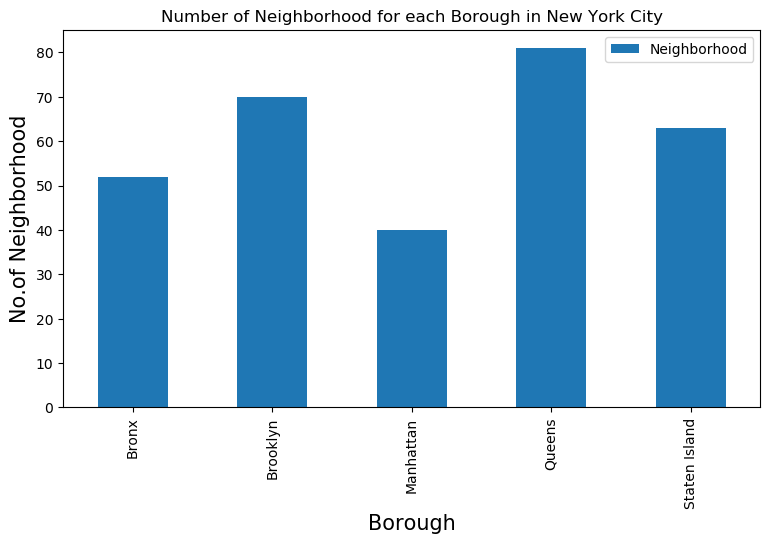

In [11]:
#So we will graph number of Neighbourhoods for this 5 borough
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_location.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [13]:
# preparing neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in df_location.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_location),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [14]:
df_indian=indian_rest_ny
df_indian.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [15]:
df_indian.shape

(151, 4)

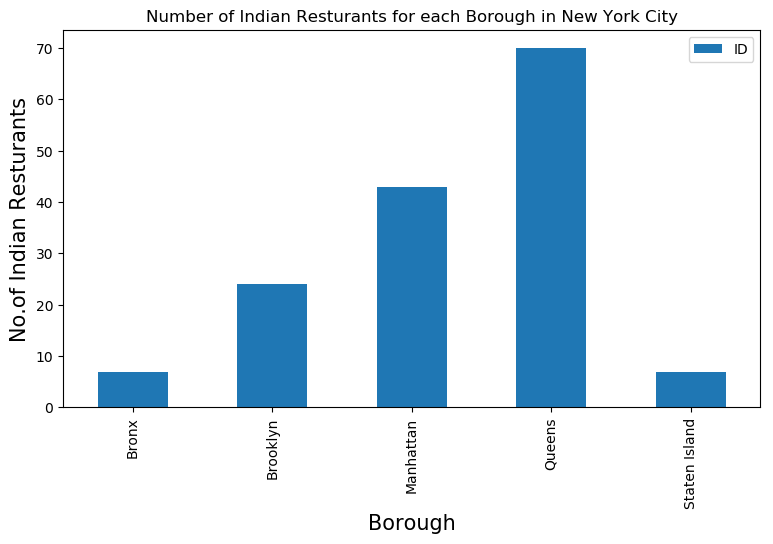

In [16]:
#plotting number of indian restaurants for each borough
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
df_indian.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

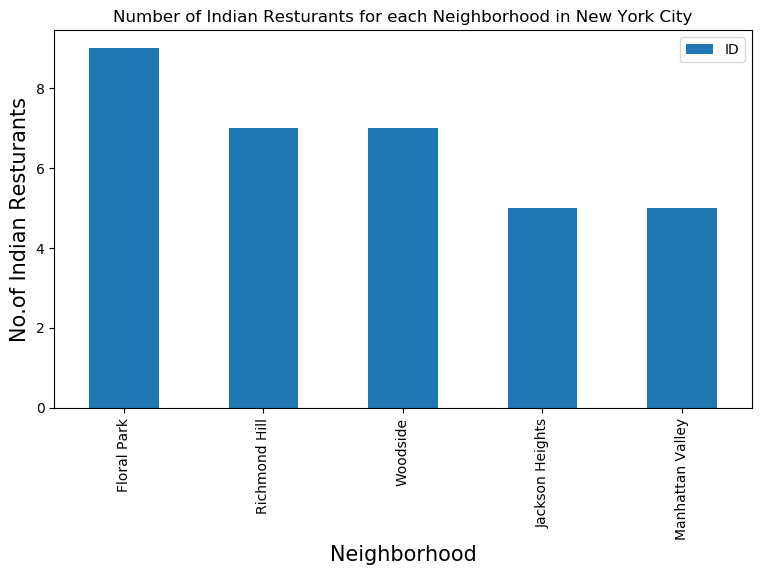

In [17]:
#since queens has highest number of idian restaurants we will analzye for its neighbourhood
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [18]:
df_indian[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
103,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
104,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
105,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
106,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
107,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
108,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
109,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
110,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
111,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [49]:
#getting ranking for each restaurant for further analysis
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
df_indian_stats=pd.DataFrame(columns=column_names)
count=1


for row in df_indian.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(df_indian),')','processed')
    df_indian_stats = df_indian_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.9    11
( 1 / 151 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.1     2
( 2 / 151 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 3 / 151 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.1     3
( 4 / 151 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.1     2
( 5 / 151 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 6 / 151 ) processed
                         ID       Name  Likes  Rat

In [50]:
df_indian_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.1,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.1,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.1,2


In [51]:
df_indian_stats.shape

(151, 7)

In [52]:
df_indian.shape

(151, 4)

In [53]:
df_indian_stats.to_csv('indian_restaurant.csv', index=False)

In [54]:
df_indian_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.1,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.1,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.1,2


In [55]:
df_indian_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
Borough         151 non-null object
Neighborhood    151 non-null object
ID              151 non-null object
Name            151 non-null object
Likes           151 non-null object
Rating          151 non-null float64
Tips            151 non-null object
dtypes: float64(1), object(6)
memory usage: 8.3+ KB


In [56]:
df_indian_stats['Likes']=df_indian_stats['Likes'].astype('float64')

In [57]:
df_indian_stats['Tips']=df_indian_stats['Tips'].astype('float64')

In [58]:
df_indian_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
Borough         151 non-null object
Neighborhood    151 non-null object
ID              151 non-null object
Name            151 non-null object
Likes           151 non-null float64
Rating          151 non-null float64
Tips            151 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.3+ KB


In [59]:
# Resturant with maximum Likes
df_indian_stats.iloc[df_indian_stats['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 37, dtype: object

In [60]:
# Resturant with maximum Rating
df_indian_stats.iloc[df_indian_stats['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              5b5a2c9e66f3cd002ca0aab5
Name                  The Drunken Munkey
Likes                                 25
Rating                                 9
Tips                                   3
Name: 39, dtype: object

In [61]:
# Resturant with maximum Tips
df_indian_stats.iloc[df_indian_stats['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                836
Rating                               8.7
Tips                                 259
Name: 37, dtype: object

In [62]:
#Now lets visualize neighborhood with maximum average rating of resturants
ny_neighborhood_stats=df_indian_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Astoria,9.0
67,Tribeca,9.0
4,Blissville,9.0
63,Sunnyside,9.0
10,Civic Center,9.0
28,Greenwich Village,9.0
73,West Village,8.9
42,Midtown South,8.7
41,Midtown,8.7
26,Gramercy,8.7


#### Above are the top neighborhoods with top average rating of Indian resturants

In [63]:
ny_borough_stats=df_indian_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.223256
1,Brooklyn,7.691667
3,Queens,6.487143
0,Bronx,5.728571
4,Staten Island,4.514286


####  these are the average rating of Indian Resturants for each Borough
Let's visualize the average rating of each borough

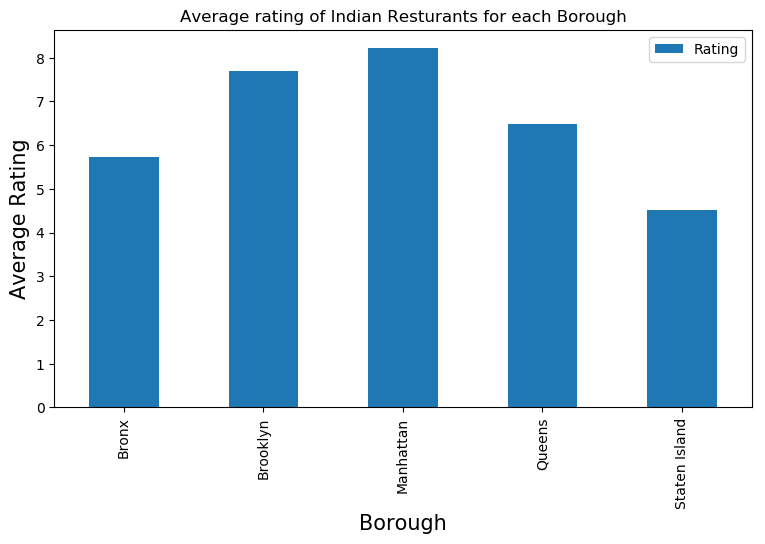

In [64]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
df_indian_stats.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()